In [12]:
# 获取URL数据（北京地铁数据）：http://map.amap.com/service/subway?_1469083453978&srhdata=1100_drw_beijing.json
# 你需要用到以下的包

import requests
import re
import numpy as np
r = requests.get('http://map.amap.com/service/subway?_1469083453978&srhdata=1100_drw_beijing.json')
#r.text

In [13]:
#方法一：正则
def get_lines_stations_info(text):
    # 请在这里写上你的代码
    # 遍历text格式数据，组成地点数据结构
    # 所有线路信息的dict：key：线路名称；value：站点名称list
    lines_info = {}
    # 所有站点信息的dict：key：站点名称；value：站点坐标(x,y)
    stations_info = {}
    lines_list = text.split("\"st\"")
    for line in lines_list:
        find_line = re.findall("\"ln\":\"(\w+)\"",line)  #查找线路
        if find_line:   
            find_station = re.findall("\"n\":\"(\w+)\"",line)  #查找该线路的所有站点
            #find_sl = re.findall("\"p\":\"\d+ \d+\"",line)
            find_sl = re.findall("\"sl\":\"(\d+.\d+),(\d+.\d+)\"",line)  #查找经纬度
            for i in range(len(find_station)):
                stations_info[find_station[i]] = tuple(map(float,find_sl[i]))
            lines_info[find_line[0]] = find_station

    return lines_info,stations_info
lines_info, stations_info = get_lines_stations_info(r.text)
#print(lines_info)
#stations_info

In [14]:
#（参考答案）方法二：正则
def get_lines_stations_info(text):
    # 遍历text格式数据，组成地点数据结构
    # 所有线路信息的dict：key：线路名称；value：站点名称list
    lines_info = {}
    # 所有站点信息的dict：key：站点名称；value：站点坐标(x,y)
    stations_info = {}

    pattern = re.compile('"st".*?"kn"')
    lines_list = pattern.findall(text)
    for i in range(len(lines_list)):
        # 地铁线路名
        pattern = re.compile('"ln":".*?"')
        line_name = pattern.findall(lines_list[i])[0][6:-1]
        # 站点信息list
        pattern = re.compile('"rs".*?"sp"')
        temp_list = pattern.findall(lines_list[i])
        station_name_list = []
        for j in range(len(temp_list)):
            # 站名
            pattern = re.compile('"n":".*?"')
            station_name = pattern.findall(temp_list[j])[0][5:-1]
            station_name_list.append(station_name)
            # 坐标(x,y)
            pattern = re.compile('"sl":".*?"')
            position = tuple(map(float, pattern.findall(temp_list[j])[0][6:-1].split(',')))
            # 数据加入站点信息dict
            stations_info[station_name] = position

        # 数据加入地铁线路dict
        lines_info[line_name] = station_name_list
    return lines_info, stations_info

lines_info, stations_info = get_lines_stations_info(r.text)
stations_info

{'金安桥': (116.163167, 39.92362),
 '四道桥': (116.13401, 39.91603),
 '桥户营': (116.125809, 39.912383),
 '上岸': (116.122225, 39.905138),
 '栗园庄': (116.123254, 39.89578),
 '小园': (116.114443, 39.890465),
 '石厂': (116.100334, 39.889378),
 '苹果园': (116.177388, 39.926727),
 '古城': (116.190337, 39.90745),
 '八角游乐园': (116.212684, 39.907442),
 '八宝山': (116.235948, 39.90744),
 '玉泉路': (116.252888, 39.907433),
 '五棵松': (116.273987, 39.907456),
 '万寿路': (116.294765, 39.907474),
 '公主坟': (116.309919, 39.907469),
 '军事博物馆': (116.321459, 39.907422),
 '木樨地': (116.337583, 39.907379),
 '南礼士路': (116.352583, 39.907234),
 '复兴门': (116.356866, 39.907242),
 '西单': (116.374072, 39.907383),
 '天安门西': (116.391278, 39.907472),
 '天安门东': (116.401216, 39.90778),
 '王府井': (116.411571, 39.908069),
 '东单': (116.41848, 39.908325),
 '建国门': (116.435806, 39.908501),
 '永安里': (116.450497, 39.908454),
 '国贸': (116.461841, 39.909104),
 '大望路': (116.475783, 39.908287),
 '四惠': (116.495456, 39.908749),
 '四惠东': (116.515664, 39.908495),
 '积水潭': (116.373126

In [15]:
#方法一
# 根据线路信息，建立站点邻接表dict
def get_neighbor_info(lines_info):
    neighbor_info = {}
    stations = set()
    
    for key in lines_info.keys():
        stations.update(lines_info[key])
    
    for station in stations:
        next_station = {}
        for line in lines_info:
            if station in lines_info[line]:
                station_index = lines_info[line].index(station)
                if station_index == 0:
                    next_station[lines_info[line][1]] = line
                elif station_index == len(lines_info[line])-1:
                    next_station[lines_info[line][station_index-1]] = line
                else:
                    next_station[lines_info[line][station_index-1]] = line
                    next_station[lines_info[line][station_index+1]] = line
        neighbor_info[station] = next_station
     
    return neighbor_info
        
neighbor_info = get_neighbor_info(lines_info)
#neighbor_info

In [16]:
#（参考答案）方法二
def get_neighbor_info(lines_info):
    # 把str2加入str1站点的邻接表中
    def add_neighbor_dict(info, str1, str2):
        list1 = info.get(str1)
        if not list1:
            list1 = []
        list1.append(str2)
        info[str1] = list1
        return info

    # 根据线路信息，建立站点邻接表dict
    neighbor_info = {}
    for line_name,station_list in lines_info.items():
        for i in range(len(station_list) - 1):
            sta1 = station_list[i]
            sta2 = station_list[i+1]
            neighbor_info = add_neighbor_dict(neighbor_info, sta1, sta2)
            neighbor_info = add_neighbor_dict(neighbor_info, sta2, sta1)
            
    return neighbor_info
        
neighbor_info = get_neighbor_info(lines_info)
neighbor_info

{'金安桥': ['四道桥', '杨庄'],
 '四道桥': ['金安桥', '桥户营'],
 '桥户营': ['四道桥', '上岸'],
 '上岸': ['桥户营', '栗园庄'],
 '栗园庄': ['上岸', '小园'],
 '小园': ['栗园庄', '石厂'],
 '石厂': ['小园'],
 '苹果园': ['古城'],
 '古城': ['苹果园', '八角游乐园'],
 '八角游乐园': ['古城', '八宝山'],
 '八宝山': ['八角游乐园', '玉泉路'],
 '玉泉路': ['八宝山', '五棵松'],
 '五棵松': ['玉泉路', '万寿路'],
 '万寿路': ['五棵松', '公主坟'],
 '公主坟': ['万寿路', '军事博物馆', '莲花桥', '西钓鱼台'],
 '军事博物馆': ['公主坟', '木樨地', '北京西站', '白堆子'],
 '木樨地': ['军事博物馆', '南礼士路'],
 '南礼士路': ['木樨地', '复兴门'],
 '复兴门': ['南礼士路', '西单', '长椿街', '阜成门'],
 '西单': ['复兴门', '天安门西', '宣武门', '灵境胡同'],
 '天安门西': ['西单', '天安门东'],
 '天安门东': ['天安门西', '王府井'],
 '王府井': ['天安门东', '东单'],
 '东单': ['王府井', '建国门', '崇文门', '灯市口'],
 '建国门': ['东单', '永安里', '朝阳门', '北京站'],
 '永安里': ['建国门', '国贸'],
 '国贸': ['永安里', '大望路', '金台夕照', '双井'],
 '大望路': ['国贸', '四惠', '金台路', '九龙山'],
 '四惠': ['大望路', '四惠东', '四惠东'],
 '四惠东': ['四惠', '四惠', '高碑店'],
 '积水潭': ['鼓楼大街'],
 '鼓楼大街': ['积水潭', '安定门', '什刹海', '安德里北街'],
 '安定门': ['鼓楼大街', '雍和宫'],
 '雍和宫': ['安定门', '东直门', '北新桥', '和平里北街'],
 '东直门': ['雍和宫', '东四十条', '柳芳', '三元桥'],
 '东四十条'

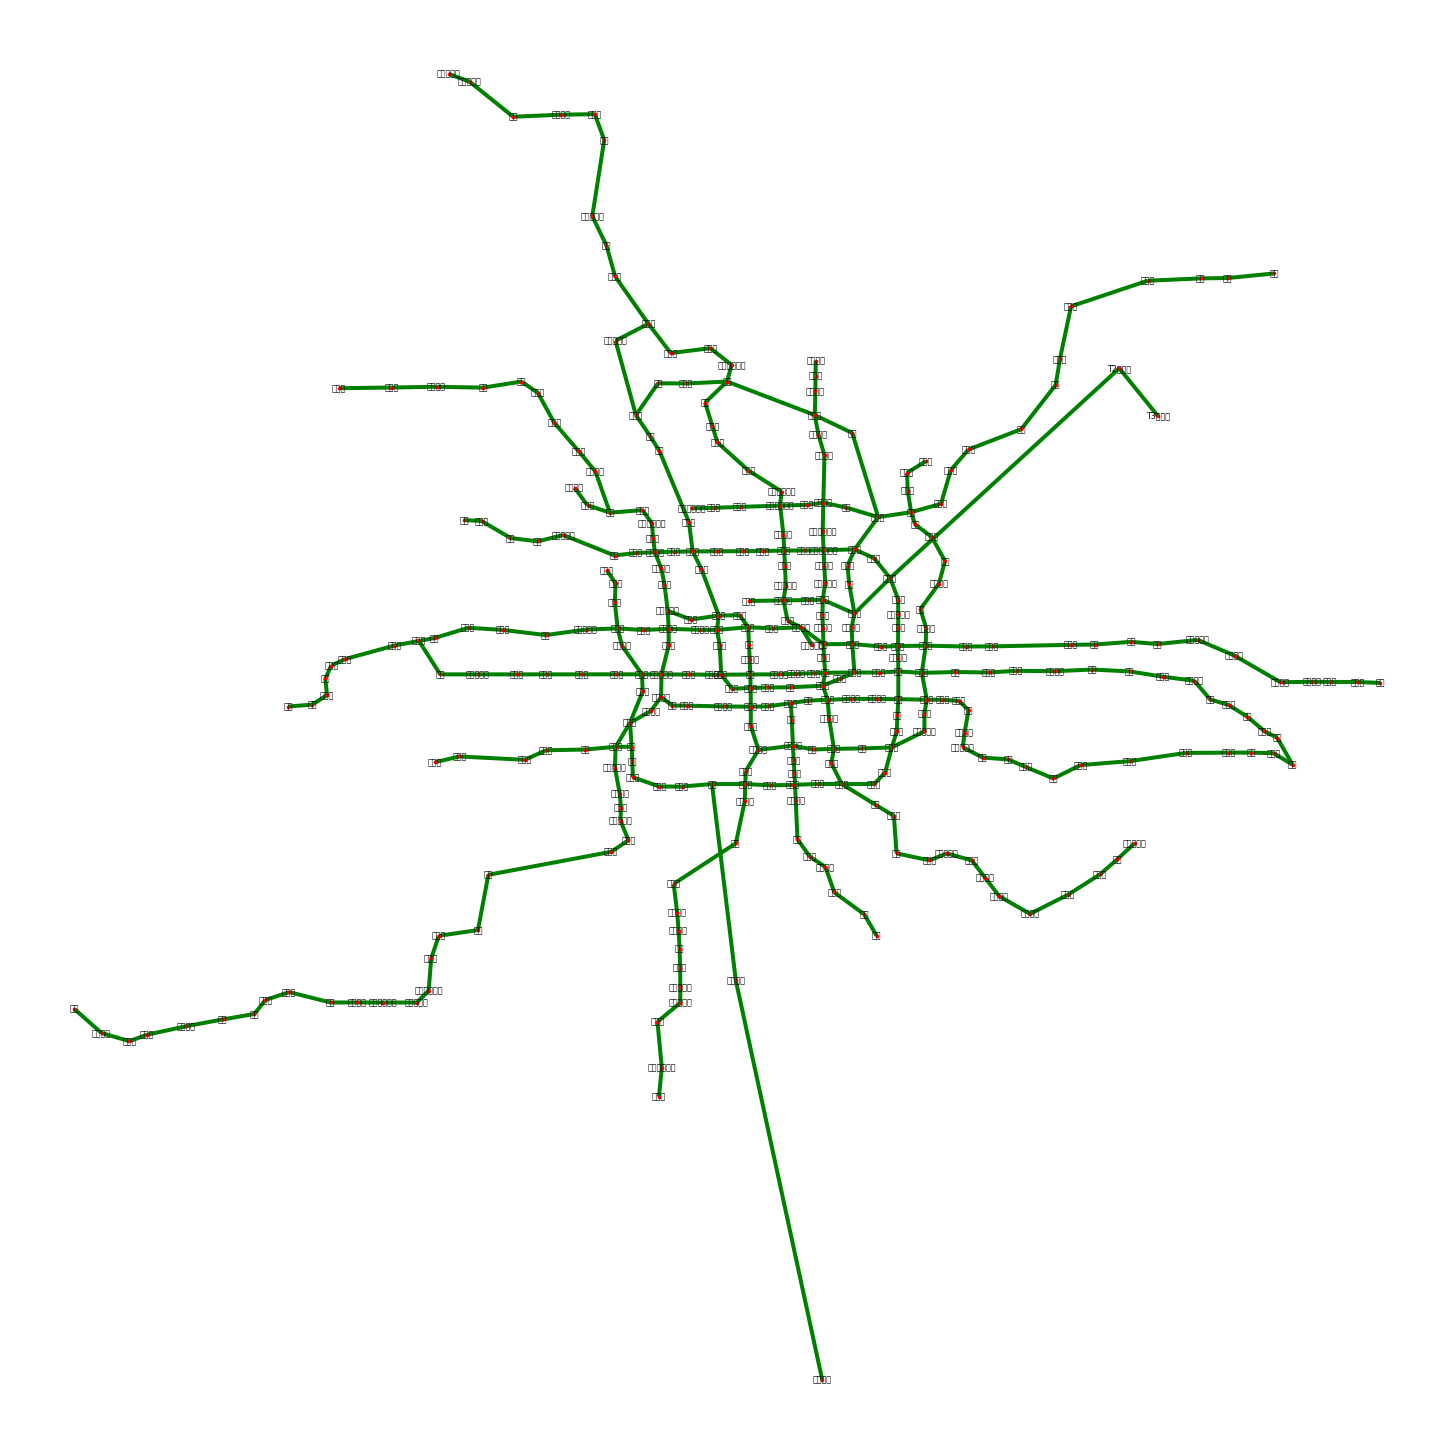

In [17]:
# 画地铁图
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

# 如果汉字无法显示，请参照
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 
matplotlib.rcParams['font.family']='sans-serif'

plt.figure(figsize=(20,20))
graph = nx.Graph(neighbor_info)
#graph.add_nodes_from(list(get_neighbor_info))
nx.draw(graph, stations_info, style='solid', font_size=8, node_color='r', edge_color='g', width=4, with_labels = True, node_size=7)


In [18]:
# (参考答案)第一种算法：递归查找所有路径
def get_path_DFS_ALL(lines_info, neighbor_info, from_station, to_station):
    # 递归算法，本质上是深度优先
    # 遍历所有路径
    # 这种情况下，站点间的坐标距离难以转化为可靠的启发函数，所以只用简单的BFS算法
    
    # 检查输入站点名称
    if not neighbor_info.get(from_station):
        print('起始站点“%s”不存在。请正确输入！'%from_station)
        return None
    if not neighbor_info.get(to_station):
        print('目的站点“%s”不存在。请正确输入！'%to_station)
        return None
    path = []
    this_station = from_station
    path.append(this_station)
    neighbors = neighbor_info.get(this_station)
    node = {'pre_station':'',
            'this_station':this_station,
            'neighbors':neighbors,
            'path':path}
    
    return get_next_station_DFS_ALL(node, neighbor_info, to_station)

def get_next_station_DFS_ALL(node, neighbor_info, to_station):
    neighbors = node.get('neighbors')
    pre_station = node.get('this_station')
    path = node.get('path')
    paths = []
    for i in range(len(neighbors)):
        this_station = neighbors[i]
        if (this_station in path):
            # 如果此站点已经在路径中，说明环路，此路不通
            return None
        if neighbors[i] == to_station:
            # 找到终点，返回路径
            path.append(to_station)
            paths.append(path)
            return paths
        else:
            neighbors_ = neighbor_info.get(this_station).copy()
            neighbors_.remove(pre_station)
            path_ = path.copy()
            path_.append(this_station)
            new_node = {'pre_station':pre_station,
                        'this_station':this_station,
                        'neighbors':neighbors_,
                        'path':path_}
            paths_ =  get_next_station_DFS_ALL(new_node, neighbor_info, to_station)
            if paths_:
                paths.extend(paths_)

    return paths

paths = get_path_DFS_ALL(lines_info, neighbor_info, '回龙观', '西二旗')
print('共有%d种路径。'%len(paths))
for item in paths:
    print("此路径总计%d站:"%(len(item)-1))
    print('-'.join(item))

KeyboardInterrupt: 

In [19]:
# （参考答案）第二种算法：没有启发函数的简单宽度优先
def get_path_BFS(lines_info, neighbor_info, from_station, to_station):
    # 搜索策略：以站点数量为cost（因为车票价格是按站算的）
    # 这种情况下，站点间的坐标距离难以转化为可靠的启发函数，所以只用简单的BFS算法
    # 由于每深一层就是cost加1，所以每层的cost都相同，算和不算没区别，所以省略
    
    # 检查输入站点名称
    if not neighbor_info.get(from_station):
        print('起始站点“%s”不存在。请正确输入！'%from_station)
        return None
    if not neighbor_info.get(to_station):
        print('目的站点“%s”不存在。请正确输入！'%to_station)
        return None
    
    # 搜索节点是个dict，key=站名，value是包含路过的站点list
    nodes = {}
    nodes[from_station] = [from_station]
    
    while True:
        new_nodes = {}
        for (k,v) in nodes.items():
            neighbor = neighbor_info.get(k).copy()
            if (len(v) >= 2):
                # 不往上一站走
                pre_station = v[-2]
                neighbor.remove(pre_station)
            for station in neighbor:
                # 遍历邻居
                if station in nodes:
                    # 跳过已搜索过的节点
                    continue
                path = v.copy()
                path.append(station)
                new_nodes[station] = path
                if station == to_station:
                    # 找到路径，结束
                    return path
        nodes = new_nodes
        
    print('未能找到路径')
    return None

paths = get_path_BFS(lines_info, neighbor_info, '回龙观', '西二旗')
print("路径总计%d站。"%(len(paths)-1))
print("-".join(paths))
# 高德导航是31站，只有1次换乘
# 代码结果是28站，但是有5次换乘
# 猜测高德的路径cost主要是时间

路径总计2站。
回龙观-龙泽-西二旗


In [ ]:
# （参考答案）第三种算法：以路径路程为cost的启发式搜索
import pandas as pd
def get_path_Astar(lines_info, neighbor_info, stations_info, from_station, to_station):
    # 搜索策略：以路径的站点间直线距离累加为cost，以当前站点到目标的直线距离为启发函数
    
    
    # 检查输入站点名称
    if not neighbor_info.get(from_station):
        print('起始站点“%s”不存在。请正确输入！'%from_station)
        return None
    if not neighbor_info.get(to_station):
        print('目的站点“%s”不存在。请正确输入！'%to_station)
        return None
    
    # 计算所有节点到目标节点的直线距离，备用
    distances = {}
    x,y = stations_info.get(to_station)
    for (k,v) in stations_info.items():
        x0,y0 = stations_info.get(k)
        l = ((x-x0)**2 + (y-y0)**2)**0.5
        distances[k] = l
        
    # 已搜索过的节点，dict
    # key=站点名称，value是已知的起点到此站点的最小cost
    searched = {}
    searched[from_station] = 0
    
    # 数据结构为pandas的dataframe
    # index为站点名称
    # g为已走路径，h为启发函数值（当前到目标的直线距离）
    nodes = pd.DataFrame([[[from_station], 0, 0, distances.get(from_station)]],
                         index=[from_station], columns=['path', 'cost', 'g', 'h']) 
    
    count = 0
    while True:
        if count > 1000:
            break
        nodes.sort_values('cost', inplace=True)
        for index, node in nodes.iterrows():
            count += 1
            # 向邻居中离目的地最短的那个站点搜索
            neighbors = neighbor_info.get(index).copy()
            if len(node['path']) >= 2:
                # 不向这个路径的反向去搜索
                neighbors.remove(node['path'][-2])
            for i in range(len(neighbors)):
                count += 1
                neighbor = neighbors[i]
                g = node['g'] + get_distance(stations_info, index, neighbor)
                h = distances[neighbor]
                cost = g + h
                path = node['path'].copy()
                path.append(neighbor)
                if neighbor == to_station:
                    # 找到目标，结束
                    print('共检索%d次。'%count)
                    return path
                if neighbor in searched:
                    if g >= searched[neighbor]:
                        # 说明现在搜索的路径不是最优，忽略
                        continue
                    else:
                        searched[neighbor] = g
                        # 修改此站点对应的node信息
#                         nodes.loc[neighbor, 'path'] = path # 这行总是报错
#                         nodes.loc[neighbor, 'cost'] = cost
#                         nodes.loc[neighbor, 'g'] = g
#                         nodes.loc[neighbor, 'h'] = h
                        # 不知道怎么修改df中的list元素，只能删除再新增行
                        nodes.drop(neighbor, axis=0, inplace=True)
                        row = pd.DataFrame([[path, cost, g, h]],
                                       index=[neighbor], columns=['path', 'cost', 'g', 'h'])
                        nodes = nodes.append(row)
                        
                else:
                    searched[neighbor] = g
                    row = pd.DataFrame([[path, cost, g, h]],
                                       index=[neighbor], columns=['path', 'cost', 'g', 'h'])
                    nodes = nodes.append(row)
            # 这个站点的所有邻居都搜索完了，删除这个节点
            nodes.drop(index, axis=0, inplace=True)

        # 外层for循环只跑第一行数据，然后重新sort后再计算
        continue         
        
    print('未能找到路径')
    return None

def get_distance(stations_info, str1, str2):
    x1,y1 = stations_info.get(str1)
    x2,y2 = stations_info.get(str2)
    return ((x1-x2)**2 + (y1-y2)**2)** 0.5

paths = get_path_Astar(lines_info, neighbor_info, stations_info, '回龙观', '西二旗')
if paths:
    print("路径总计%d站。"%(len(paths)-1))
    print("-".join(paths))
# 高德导航是31站，只有1次换乘
# 代码结果是28站，与以地铁站数为cost的结果相同，但是路径不同（从第一种遍历的算法能看到，28站到达目的地的路径有3种）
# 猜测高德的路径cost主要是时间

In [ ]:
#最小换乘

#  你也可以使用第二种算法：没有启发函数的简单宽度优先

def get_path_BFS(lines_info, neighbor_info, from_station, to_station):
    # 搜索策略：以站点数量为cost（因为车票价格是按站算的）
    # 这种情况下，站点间的坐标距离难以转化为可靠的启发函数，所以只用简单的BFS算法
    # 由于每深一层就是cost加1，所以每层的cost都相同，算和不算没区别，所以省略
    # 检查输入站点名称
    if from_station == to_station:
        return [from_station]

    pathes = [ [ from_station, ('',0)] ]
    
    while(pathes):
        path = pathes.pop(0)
        froniter = path[-2]
        previous_line, transfer_times = path[-1]
        
        successors = neighbor_info[froniter]
        
        for station in successors:
            if station in path:continue
            
            linechange = transfer_times
            if previous_line != successors[station]:
                linechange += 1
                
            new_path = path[:-1] + [station, (successors[station],linechange)]
            if station == to_station:
                return new_path[:-1]
            else:
                pathes.append(new_path)
                pathes.sort(key=lambda path:path[-1][-1])

print(get_path_BFS(lines_info, neighbor_info, '顺义', '天通苑'))


In [ ]:
#  你也可以使用第二种算法：没有启发函数的简单宽度优先

def get_path_BFS(lines_info, neighbor_info, from_station, to_station):
    if from_station == to_station:
        return [from_station]
    
    pathes = [ [ from_station] ]
    
    while(pathes):
        path = pathes.pop(0)
        froniter = path[-1]
        
        successors = neighbor_info[froniter]
        
        for station in successors:
            if station in path:continue
            
            new_path = path + [station]
            #print(new_path)
            if station == to_station:
                return new_path
            else:
                pathes.append(new_path)

print(get_path_BFS(lines_info, neighbor_info, '人民大学', '青年路'))